In [1]:
import yaml
import numpy as np
import pandas as pd
import plotnine
from plotnine import *
from pathlib import Path
from joblib import Parallel, delayed
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

from sklearn.base import clone
from sklearn.utils import resample
from sklearn.impute import KNNImputer
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import LinearRegression, ElasticNet, PoissonRegressor
from sklearn.preprocessing import StandardScaler, FunctionTransformer, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold, cross_val_score
from sklearn.metrics import r2_score, auc, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR

In [2]:
blue = '#4E79A7'
orange = '#F28E2B'
lightgray = '#C7C7C7'

In [3]:
project_dir = Path.cwd().resolve().parent

In [4]:
with (project_dir / 'config.yml').open('r') as f:
    config = yaml.safe_load(f)

In [5]:
input_dir = Path(config['wenhan_processed_data_directory'])

In [6]:
random_state = 1234

### 0. Prepare data

Load and format study metadata

In [7]:
df_metadata = pd.read_csv(
    input_dir / 'GSE79362_GSE103147_MultivariateModel_Info.csv')

In [8]:
df_metadata = df_metadata.rename({
    'Unnamed: 0': 'sample_id'}, axis=1)

In [9]:
def scale_outcome(y):
    if y == 0:
        y_ = 0
    elif y == 1:
        y_ = 1 - 0.8*(630./720.)
    elif y == 2:
        y_ = 1 - 0.8*(450./720.)
    elif y == 3:
        y_ = 1 - 0.8*(270./720.)
    elif y == 4:
        y_ = 1 - 0.8*(90./720.)
    elif y == 5:
        y_ = 1.
    return str(y_)

In [10]:
df_metadata['group'] = df_metadata['group'].apply(scale_outcome)

In [11]:
df_metadata = df_metadata.set_index('sample_id')[['group']]

Load normalized gene expression values

In [12]:
df_expression = pd.read_csv(
    input_dir / 'GSE79362_GSE103147_MultivariateModel_Exp_EachGene.csv', index_col=0).T

### 1. Screen features (genes) with either network analysis

In [13]:
with (project_dir / 'data' / 'roger_gene_set.txt').open('r') as f:
    roger_gene_list = [x.strip() for x in f.readlines()]

In [14]:
df_expression_screened = df_expression.loc[:, [x for x in roger_gene_list if x in df_expression.columns]]

In [15]:
df = pd.merge(df_metadata, df_expression_screened, left_index=True, right_index=True, how='inner')

In [16]:
X = df.drop('group', axis=1)
y = df['group']

Split outcomes and features into training and test sets

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

Prepare outer and inner cross-validation folds

In [18]:
outer_cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=random_state)
inner_cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=random_state)

Preprocess features by imputing missing values and scaling

In [19]:
preprocessor = Pipeline([
    #('oversampler', SMOTE(k_neighbors=3, random_state=random_state, n_jobs=-1)),
    ('imputer', KNNImputer(n_neighbors=5, weights='uniform')),
    ('scaler', StandardScaler())
])

Define a set of regressor models, their hyperparameter search spaces, and the evaluation metric

In [20]:
regressors = {
    'random_forest': {
        'model': RandomForestRegressor(n_jobs=-1, random_state=random_state),
        'params': {
            'n_estimators': [100],
            'max_features': ['auto', 'sqrt', 'log2']
        },
        'scorer': 'r2'
    },
    
    'elastic_net': {
        'model': ElasticNet(max_iter=int(1e6), random_state=random_state),
        'params': {
            'alpha': np.logspace(-5, 2, num=10), 
            'l1_ratio': np.arange(0, 1.1, 0.1)
        },
        'scorer': 'r2'
    },
    
    'linear_regression': {
        'model': LinearRegression(n_jobs=-1),
        'params': {},
        'scorer': 'r2'
    },
    
    'support_vector_machine': {
        'model': SVR(),
        'params': {
            'kernel': ['linear', 'poly', 'rbf'],
            'gamma': ['scale', 'auto'],
            'C': np.logspace(-5, 2, num=8)
        },
        'scorer': 'r2'
    },
    
    'adaboost': {
        'model': AdaBoostRegressor(random_state=random_state),
        'params': {
            'n_estimators': np.arange(10, 101, 10),
            'loss': ['linear', 'square', 'exponential']
        },
        'scorer': 'r2'
    }
}

Use inner cross-validation folds to optimize hyperparameters for different regressors

In [21]:
optimized_models = []

for name, opts in regressors.items():
    pipeline = clone(preprocessor)
    pipeline.steps.append(('model', opts['model']))
    
    param_grid = {f'model__{k}': v for k, v in opts['params'].items()}

    optimized_model = GridSearchCV(
        estimator=pipeline, n_jobs=-1, refit=True,
        param_grid=param_grid, cv=inner_cv,
        scoring=opts['scorer'])
    
    optimized_model.fit(X_train, y_train)
    
    optimized_models.append({
        'name': name,
        'model': optimized_model,
        'scorer': opts['scorer'],
        'inner_cv': optimized_model.best_score_
    })
    
df_scores = pd.DataFrame(optimized_models)

/shared/software/anaconda3/envs/tb-gene-signature/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.961966929981792, tolerance: 0.002318959064327485


Evaluate performance of optimized models on outer cross-validation folds

In [22]:
df_scores['outer_cv'] = df_scores.apply(
    lambda regressor:
        cross_val_score(
            regressor['model'].best_estimator_, X, y,
            scoring=regressor['scorer'], cv=outer_cv,
            n_jobs=-1).mean(), axis=1)

In [23]:
df_scores

,name,model,scorer,inner_cv,outer_cv
0,random_forest,"GridSearchCV(cv=RepeatedKFold(n_repeats=5, n_s...",r2,0.257538,0.268618
1,elastic_net,"GridSearchCV(cv=RepeatedKFold(n_repeats=5, n_s...",r2,0.388145,0.420953
2,linear_regression,"GridSearchCV(cv=RepeatedKFold(n_repeats=5, n_s...",r2,0.234002,0.343203
3,support_vector_machine,"GridSearchCV(cv=RepeatedKFold(n_repeats=5, n_s...",r2,0.365811,0.380498
4,adaboost,"GridSearchCV(cv=RepeatedKFold(n_repeats=5, n_s...",r2,0.276189,0.244302


Predict training and test set outcomes with optimized models

In [24]:
y_train_hat_list = []
for idx, regressor in df_scores.iterrows():
    y_train_hats = regressor['model'].predict(X_train).flatten()
    for i, y_train_hat in enumerate(y_train_hats):
        y_train_hat_list.append({
            'model_name': regressor['name'],
            'sample_id': y_train.index[i],
            'y_train': float(y_train[i]),
            'y_train_hat': y_train_hat
        })
df_y_train_hats = pd.DataFrame(y_train_hat_list)

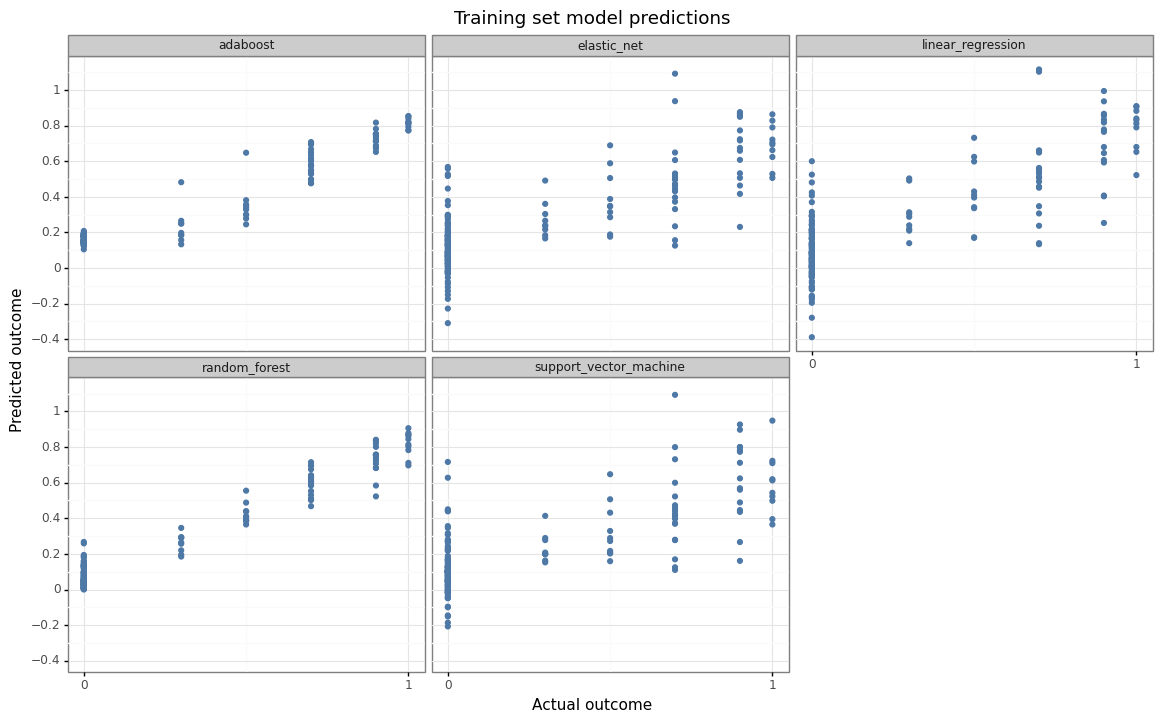

In [25]:
plotnine.options.figure_size = (14, 8)
(
    ggplot(
        df_y_train_hats) +
    geom_point(
        aes(x='y_train',
            y='y_train_hat'),
        color=blue) +
    facet_wrap(
        '~ model_name', ncol=3) +
    scale_x_continuous(
        breaks=np.arange(0, 6, 1)) +
    scale_y_continuous(
        breaks=np.arange(-1, 1.1, 0.2)) +
    labs(
        x='Actual outcome',
        y='Predicted outcome',
        title='Training set model predictions') +
    theme_bw() + 
    theme(
        strip_background_y=element_text(color='white'))
).draw();

In [26]:
y_test_hat_list = []
for idx, regressor in df_scores.iterrows():
    y_test_hats = regressor['model'].predict(X_test).flatten()
    for i, y_test_hat in enumerate(y_test_hats):
        y_test_hat_list.append({
            'model_name': regressor['name'],
            'sample_id': y_test.index[i],
            'y_test': float(y_test[i]),
            'y_test_hat': y_test_hat
        })
df_y_test_hats = pd.DataFrame(y_test_hat_list)

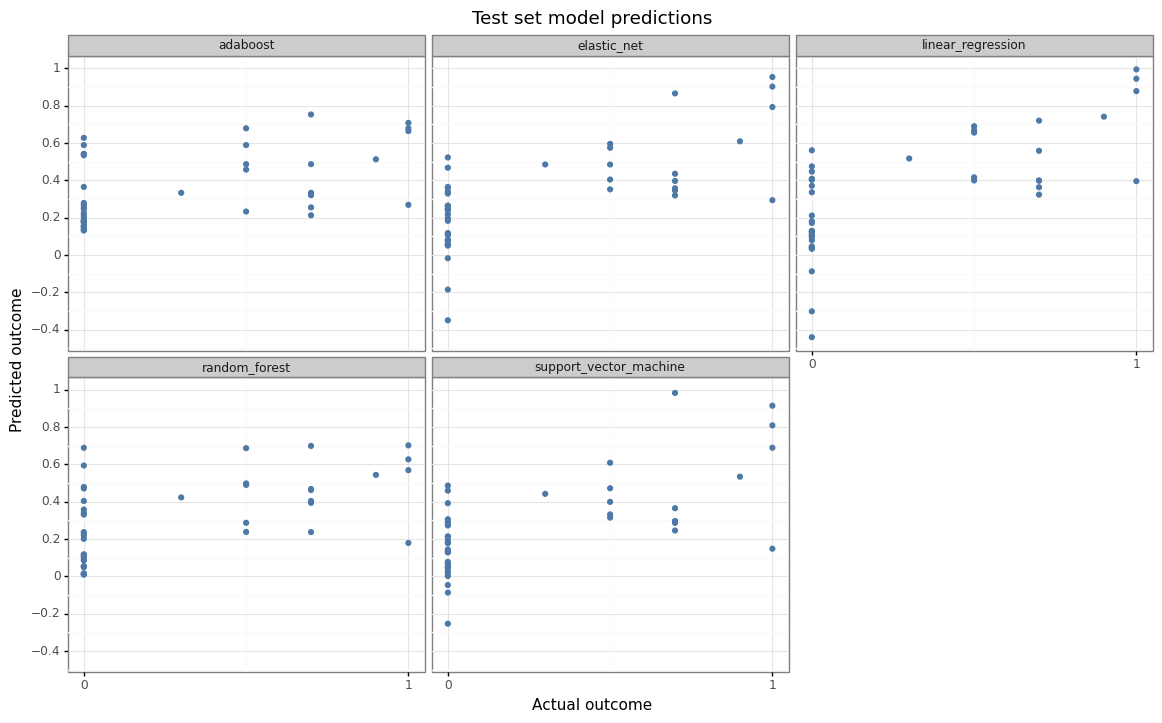

In [27]:
plotnine.options.figure_size = (14, 8)
(
    ggplot(
        df_y_test_hats) +
    geom_point(
        aes(x='y_test',
            y='y_test_hat'),
        color=blue) +
    facet_wrap(
        '~ model_name', ncol=3) +
    scale_x_continuous(
        breaks=np.arange(0, 6, 1)) +
    scale_y_continuous(
        breaks=np.arange(-1, 1.1, 0.2)) +
    labs(
        x='Actual outcome',
        y='Predicted outcome',
        title='Test set model predictions') +
    theme_bw() + 
    theme(
        strip_background_y=element_text(color='white'))
).draw();

### 2. Screen features with bootstrap stability analysis

In [28]:
def fit_bootstrap_sample(
    df_X, srs_y, pipeline, model_name, lambda_name,
        lambda_val, n_samples_in_bootstrap):
    """
    """
    df_X_, srs_y_ = resample(
        df_X.values, srs_y, n_samples=n_samples_in_bootstrap)
    
    pipeline.set_params(
        **{f'{model_name}__{lambda_name}': lambda_val})
    pipeline.fit(df_X_, srs_y_)
    
    coefs = pipeline.named_steps[model_name].coef_
    
    # if numeric outcome, len(coefs)==1; if categorical len(coefs)=# categories
    if len(coefs.shape) == 1:
        coefs = coefs.reshape((1, -1))

    # trickier when categorical
    bootstrap_mask = np.any(coefs != 0.0, axis=0)

    return bootstrap_mask

In [29]:
def compute_feature_stability_scores(
    df_X, srs_y, method='max', threshold=0.4, lambda_grid=np.logspace(-4, 0, num=25),
        n_bootstraps=100, n_samples_in_bootstrap=None, l1_ratio=1.0, random_state=None):
    """
    """
    if n_samples_in_bootstrap is None:
        n_samples_in_bootstrap = int(df_X.shape[0]/2)
        
    model_name = 'elasticnet'
    lambda_name = 'alpha'
        
    pipeline = Pipeline([
        ('imputer',
            KNNImputer(
                n_neighbors=5, weights='uniform')),
        ('scaler',
            StandardScaler()),
        (model_name, 
            ElasticNet(
                l1_ratio=1.0, max_iter=1e5,
                random_state=random_state))
    ])
    
    stability_scores_list = []
    
    for lambda_idx, lambda_val in enumerate(lambda_grid):
        bootstrap_mask_list = Parallel(n_jobs=-1)(
            delayed(fit_bootstrap_sample)(
                df_X, srs_y, pipeline, model_name, lambda_name,
                lambda_val, n_samples_in_bootstrap)
            for _ in range(n_bootstraps))
        
        bootstrap_mask_matrix = np.hstack([
            x.reshape((-1, 1)) for x in bootstrap_mask_list])

        stability_scores = bootstrap_mask_matrix.mean(axis=1)
        stability_scores_list.append(stability_scores)
        
    stability_scores_matrix = np.hstack([
        x.reshape((-1, 1)) for x in stability_scores_list])

    stability_scores_df = pd.DataFrame(
        stability_scores_matrix, index=df_X.columns, columns=lambda_grid)
    
    stability_scores_df = stability_scores_df.reset_index()
    stability_scores_df = stability_scores_df.rename({'index': 'feature'}, axis=1)
    
    stability_scores_df = stability_scores_df.melt(
        id_vars='feature', var_name='lambda', value_name='stability_score')

    stability_scores_df['lambda'] = stability_scores_df['lambda'].astype(float)
    stability_scores_df = stability_scores_df.sort_values(['lambda', 'feature'])
    stability_scores_df = stability_scores_df.set_index('feature')
    
    group = stability_scores_df.groupby(stability_scores_df.index)

    if method == 'max':
        stability_scores = pd.DataFrame(group['stability_score'].max())

    elif method == 'auc':
        stability_scores = pd.DataFrame(
            group[['lambda', 'stability_score']].apply(
                lambda x: auc(x['lambda'], x['stability_score'])))
        stability_scores = stability_scores.rename({0: 'stability_score'}, axis=1)
        
    stability_scores['is_stable'] = stability_scores['stability_score'] >= threshold
    stable_features = list(
        stability_scores['is_stable'].index[stability_scores['is_stable']])
    
    return {
        'scores': stability_scores,
        'lambda_path': stability_scores_df,
        'stable_features': stable_features
    }

In [30]:
def fit_inner_cv_regressor_model(X, y, preprocessor, regressor, params, cv):
    """
    """
    pipeline = clone(preprocessor)
    pipeline.steps.append(('regressor', regressor))
    
    param_grid = {f'regressor__{k}': v for k, v in params.items()}

    regression_model = GridSearchCV(
        estimator=pipeline, scoring='neg_root_mean_squared_error',
        n_jobs=-1, refit=True, param_grid=param_grid, cv=cv)
    
    regression_model.fit(X, y)
    
    return regression_model

In [31]:
df = pd.merge(df_metadata, df_expression, left_index=True, right_index=True, how='inner')

In [32]:
X = df.drop('group', axis=1)
y = df['group']

Split outcomes and features into training and test sets

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

In [34]:
stability_scores = compute_feature_stability_scores(X_train, y_train, method='auc', threshold=0.05)

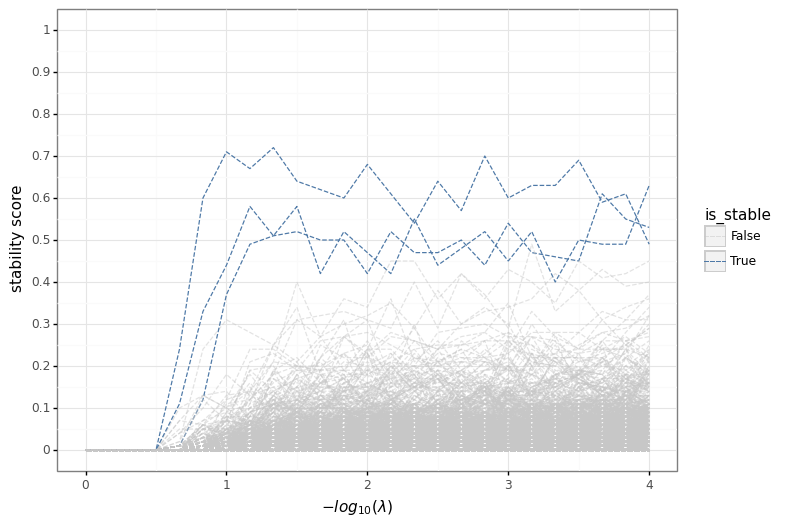

In [35]:
df_plot = stability_scores['lambda_path'].copy().reset_index()
df_plot['lambda_neg_log10'] = -np.log10(df_plot['lambda'])

df_plot = df_plot.merge(
    stability_scores['scores'][['is_stable']],
    how='inner', left_on='feature', right_index=True)

plotnine.options.figure_size = (8, 6)
(
    ggplot(df_plot) +
    geom_line(
        aes(x='lambda_neg_log10',
            y='stability_score',
            group='feature',
            color='is_stable',
            alpha='is_stable'),
        linetype='dashed') +
    scale_x_continuous(
        breaks=np.arange(0, 5, 1)) +
    scale_y_continuous(
        breaks=np.arange(0, 1.1, 0.1)) +
    scale_color_manual(
        values=[lightgray, blue]) +
    scale_alpha_manual(
        values=[0.5, 1.0]) +
    coord_cartesian(
        ylim=[0, 1]) +
    labs(
        x='$-log_{10}(\lambda)$',
        y='stability score') +
    theme_bw()
).draw();

In [36]:
X_train = X_train.loc[:, stability_scores['stable_features']]
X_test = X_test.loc[:, stability_scores['stable_features']]

In [37]:
X_train.shape[1] # number of features remaining

3

Prepare outer and inner cross-validation folds

In [38]:
outer_cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=random_state)
inner_cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=random_state)

In [39]:
optimized_models = []

for name, opts in regressors.items():
    pipeline = clone(preprocessor)
    pipeline.steps.append(('regressor', opts['model']))
    
    param_grid = {f'regressor__{k}': v for k, v in opts['params'].items()}

    optimized_model = GridSearchCV(
        estimator=pipeline, n_jobs=-1, refit=True,
        param_grid=param_grid, cv=inner_cv,
        scoring=opts['scorer'])
    
    optimized_model.fit(X_train, y_train)
    
    optimized_models.append({
        'name': name,
        'model': optimized_model,
        'scorer': opts['scorer'],
        'inner_cv': optimized_model.best_score_
    })
    
df_scores = pd.DataFrame(optimized_models)

/shared/software/anaconda3/envs/tb-gene-signature/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.885703661633796, tolerance: 0.002318959064327485


Evaluate performance of optimized models on outer cross-validation folds

In [40]:
df_scores['outer_cv'] = df_scores.apply(
    lambda regressor:
        cross_val_score(
            regressor['model'].best_estimator_, X, y,
            scoring=regressor['scorer'], cv=outer_cv,
            n_jobs=-1).mean(), axis=1)

In [41]:
df_scores

,name,model,scorer,inner_cv,outer_cv
0,random_forest,"GridSearchCV(cv=RepeatedKFold(n_repeats=5, n_s...",r2,0.272682,0.193058
1,elastic_net,"GridSearchCV(cv=RepeatedKFold(n_repeats=5, n_s...",r2,0.362386,0.549854
2,linear_regression,"GridSearchCV(cv=RepeatedKFold(n_repeats=5, n_s...",r2,0.359521,0.549984
3,support_vector_machine,"GridSearchCV(cv=RepeatedKFold(n_repeats=5, n_s...",r2,0.345890,0.480057
4,adaboost,"GridSearchCV(cv=RepeatedKFold(n_repeats=5, n_s...",r2,0.257708,0.078764


Predict training and test set outcomes with optimized models

In [42]:
y_train_hat_list = []
for idx, regressor in df_scores.iterrows():
    y_train_hats = regressor['model'].predict(X_train).flatten()
    for i, y_train_hat in enumerate(y_train_hats):
        y_train_hat_list.append({
            'model_name': regressor['name'],
            'sample_id': y_train.index[i],
            'y_train': float(y_train[i]),
            'y_train_hat': y_train_hat
        })
df_y_train_hats = pd.DataFrame(y_train_hat_list)

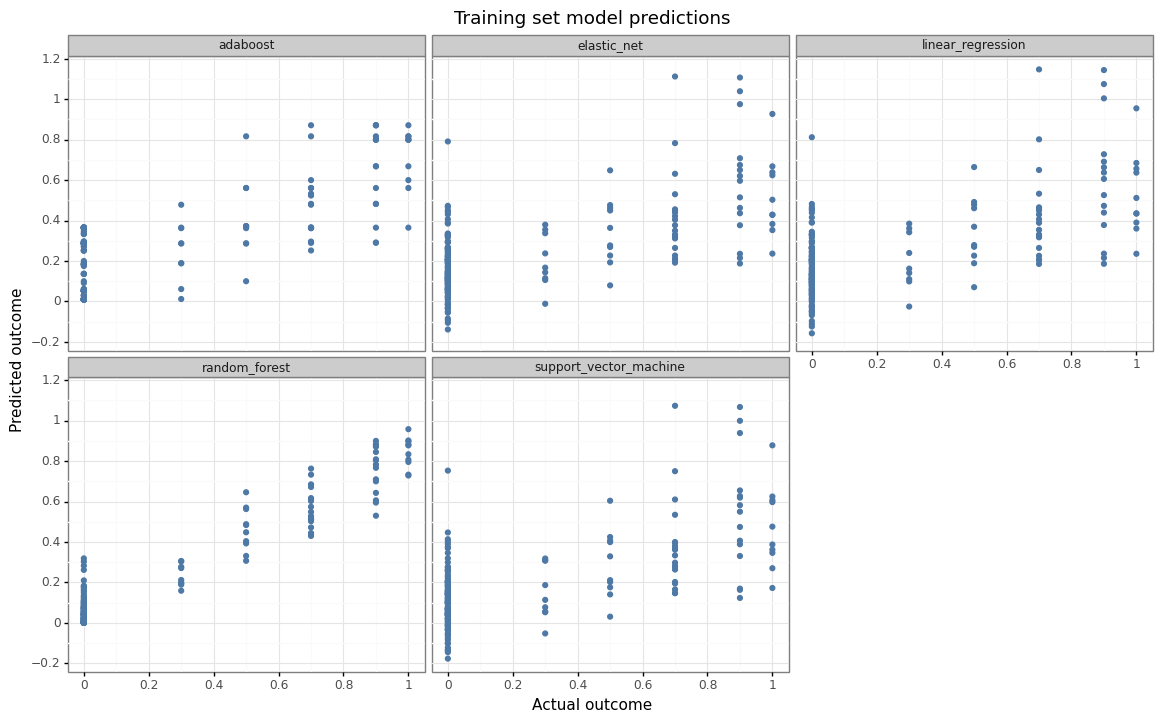

In [43]:
plotnine.options.figure_size = (14, 8)
(
    ggplot(
        df_y_train_hats) +
    geom_point(
        aes(x='y_train',
            y='y_train_hat'),
        color=blue) +
    facet_wrap(
        '~ model_name', ncol=3) +
    scale_x_continuous(
        breaks=np.arange(0, 1.1, 0.2)) +
    scale_y_continuous(
        breaks=np.arange(-1, 1.5, 0.2)) +
    labs(
        x='Actual outcome',
        y='Predicted outcome',
        title='Training set model predictions') +
    theme_bw() + 
    theme(
        strip_background_y=element_text(color='white'))
).draw();

In [44]:
y_test_hat_list = []
for idx, regressor in df_scores.iterrows():
    y_test_hats = regressor['model'].predict(X_test).flatten()
    for i, y_test_hat in enumerate(y_test_hats):
        y_test_hat_list.append({
            'model_name': regressor['name'],
            'sample_id': y_test.index[i],
            'y_test': float(y_test[i]),
            'y_test_hat': y_test_hat
        })
df_y_test_hats = pd.DataFrame(y_test_hat_list)

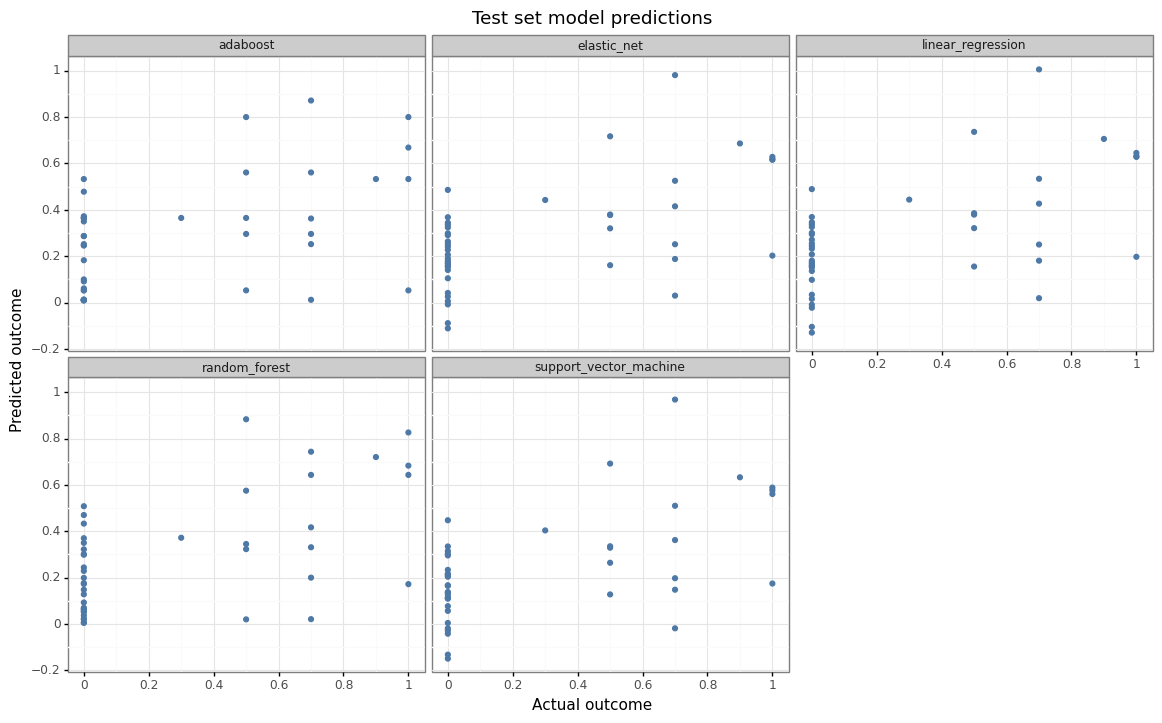

In [45]:
plotnine.options.figure_size = (14, 8)
(
    ggplot(
        df_y_test_hats) +
    geom_point(
        aes(x='y_test',
            y='y_test_hat'),
        color=blue) +
    facet_wrap(
        '~ model_name', ncol=3) +
    scale_x_continuous(
        breaks=np.arange(0, 1.1, 0.2)) +
    scale_y_continuous(
        breaks=np.arange(-1, 1.5, 0.2)) +
    labs(
        x='Actual outcome',
        y='Predicted outcome',
        title='Test set model predictions') +
    theme_bw() + 
    theme(
        strip_background_y=element_text(color='white'))
).draw();